# Set up

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import scvelo as scv

/tmp/ipykernel_4162704/480886881.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scv.settings.verbosity = 3
scv.logging.print_version()

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
absl                NA
asciitree           NA
asttokens           NA
attr                23.2.0
backcall            0.2.0
chex                0.1.85
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
docrep              0.3.2
etils               1.5.2
exceptiongroup      1.2.0
executing           0.8.3
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.10.8
importlib_resources NA
ipykernel           6.28.0
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.18.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
louvain             0.8.1
matplotlib 

In [3]:
scv.settings.set_figure_params('scvelo')

# Load and process

In [4]:
cell = 'treg'

In [5]:
# work dir
work_dir = '/work/home/project/scESCA/200227_6samples'
afile = '%s/output/04.rm_cells/seurat_treg.h5ad' %(work_dir)
adata = sc.read(afile, cache=False)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 14691 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Source', 'Tissue', 'Origin', 'percent.mt', 'percent.heat', 'percent.dissociation', 'percent.ribo', 'mRNA.catabolic', 'ribonuclease.activity', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1.2', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'Metastasis', 'VDJ', 'IGHC', 'Drainage', 'Origin2', 'Origin3', 'level_3', 'Metastasis_n', 'Origin2_n', 'Metastatic', 'Origin4'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_dt', 'X_pca', 'X_tsne', 'X_umap'

In [6]:
# read velocity adata
vfile = '/work/home/project/scESCA/cellranger/200227_6samples/velocyto/200227_6samples.h5ad'
vdata = scv.read(vfile, cache=False)
vdata.var_names_make_unique()
vdata

AnnData object with n_obs × n_vars = 657589 × 58288
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'spliced', 'unspliced'

In [7]:
# filter cells
cells = adata.obs.index.to_list()
vdata = vdata[cells, :]

In [8]:
# vdata meta
meta = ['seurat_clusters', 'Tissue', "Patient", 'Origin', 'Source', 'level_3']
vdata.obs = adata.obs[meta]

In [9]:
# add umap
vdata.obsm['X_umap'] = adata.obsm['X_umap']

In [10]:
# set order and colors
level_3_color_maps = {"Treg-C1" : "#1f77b4",  "Treg-C2" : "#ff7f0e",
                      "Treg-C3" : "#279e68"}

# level3
level3 = []
level3_colors = []
for t in list(level_3_color_maps.keys()):
    if t in vdata.obs['level_3'].unique():
        level3.append(t)
        level3_colors.append(level_3_color_maps[t])
vdata.uns['level_3_colors'] = level3_colors
vdata.obs['level_3'] = vdata.obs['level_3'].astype('object')
vdata.obs['level_3'] = vdata.obs['level_3'].astype('category')
vdata.obs['level_3'] = vdata.obs['level_3'].cat.reorder_categories(level3)

In [11]:
# preprocessing
scv.utils.cleanup(vdata)
# copy one
vdata_raw = vdata.copy()

# preprocess
scv.pp.filter_and_normalize(vdata, min_shared_counts=10, n_top_genes=2000)
scv.pp.moments(vdata, n_pcs=30, n_neighbors=30)

Filtered out 50207 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30


/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:03)
computing neighbors
    finished (0:00:26) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# stochastic model

In [12]:
model = "stochastic"

In [13]:
# compute velocity and velocity graph
vdata._isview = False # this is a bug in the scvelo package
scv.tl.velocity(vdata)
scv.tl.velocity_graph(vdata)

computing velocities


/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/14691 [00:00<?, ?cells/s]

    finished (0:00:37) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvel

saving figure to file ./figures/scvelo_treg.scvelo_stochastic.on_grid.pdf


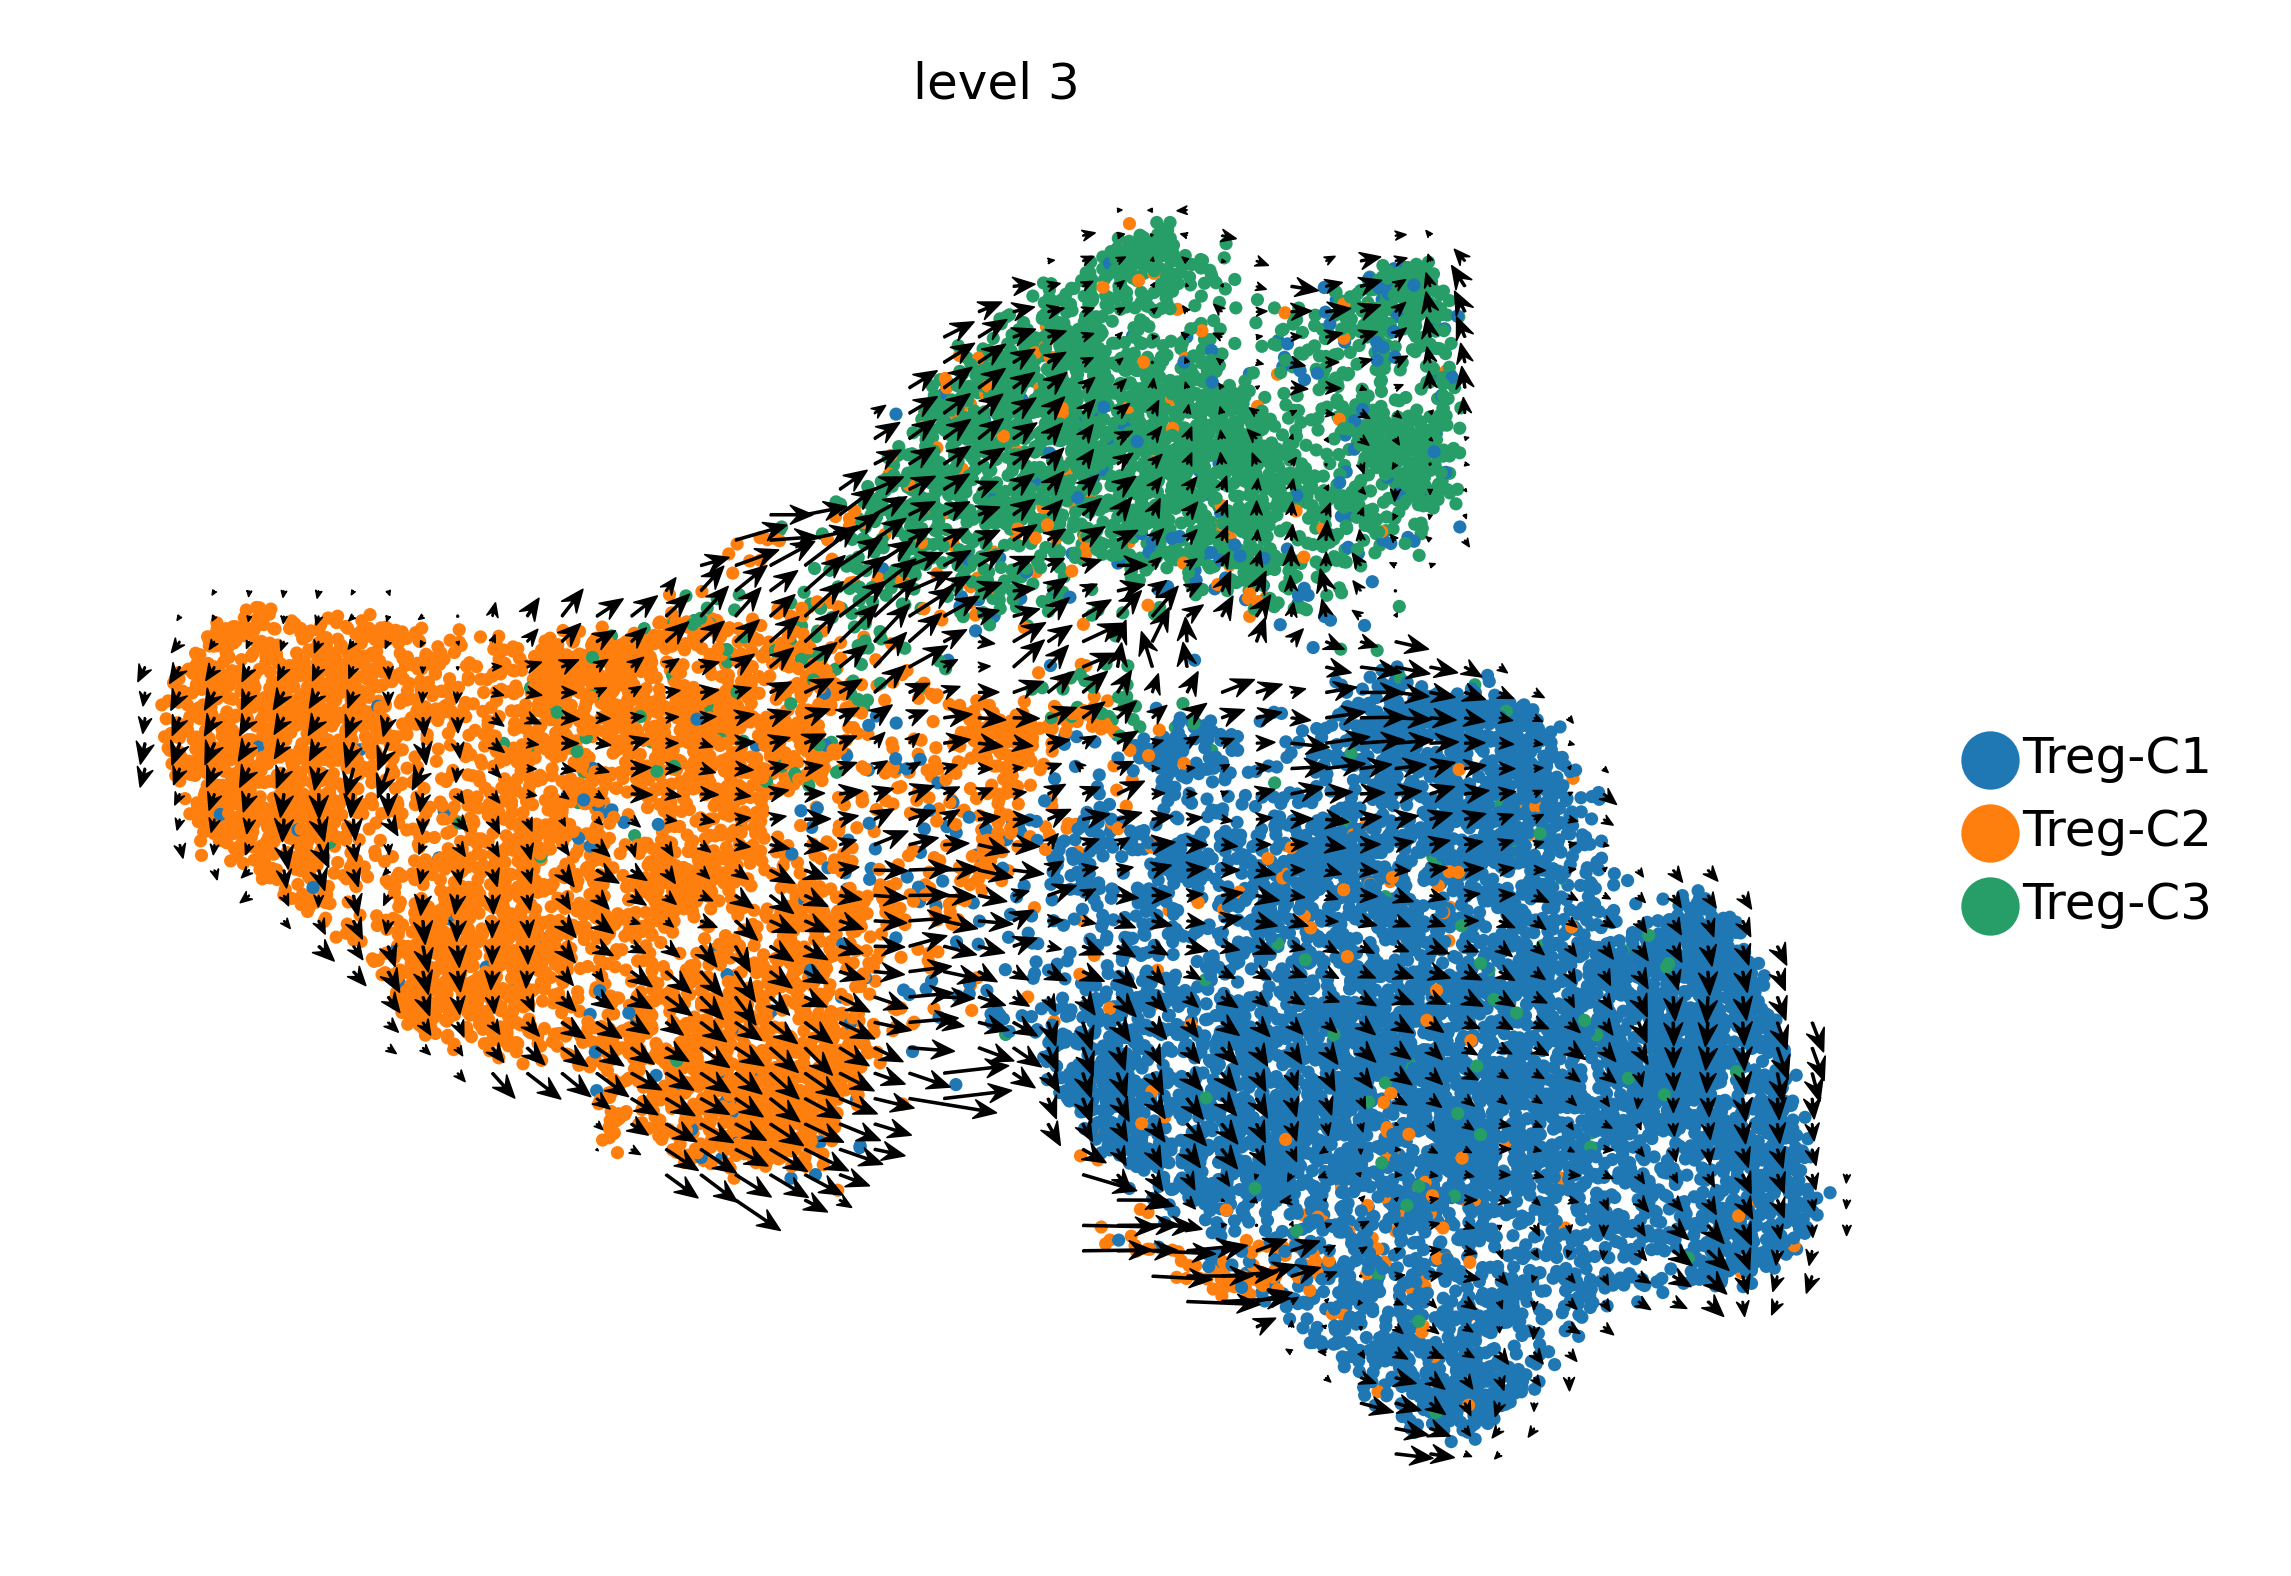

In [14]:
scv.pl.velocity_embedding_grid(vdata, basis='umap', color=['level_3'], arrow_size=2, arrow_length=2, arrow_color='black', legend_loc='right',
                              figsize=(4, 3), alpha=1, dpi=300, fontsize=6, legend_fontsize=6, size = 10, save=f"{cell}.scvelo_{model}.on_grid.pdf")

/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvel

saving figure to file ./figures/scvelo_treg.scvelo_stochastic.on_stream.svg


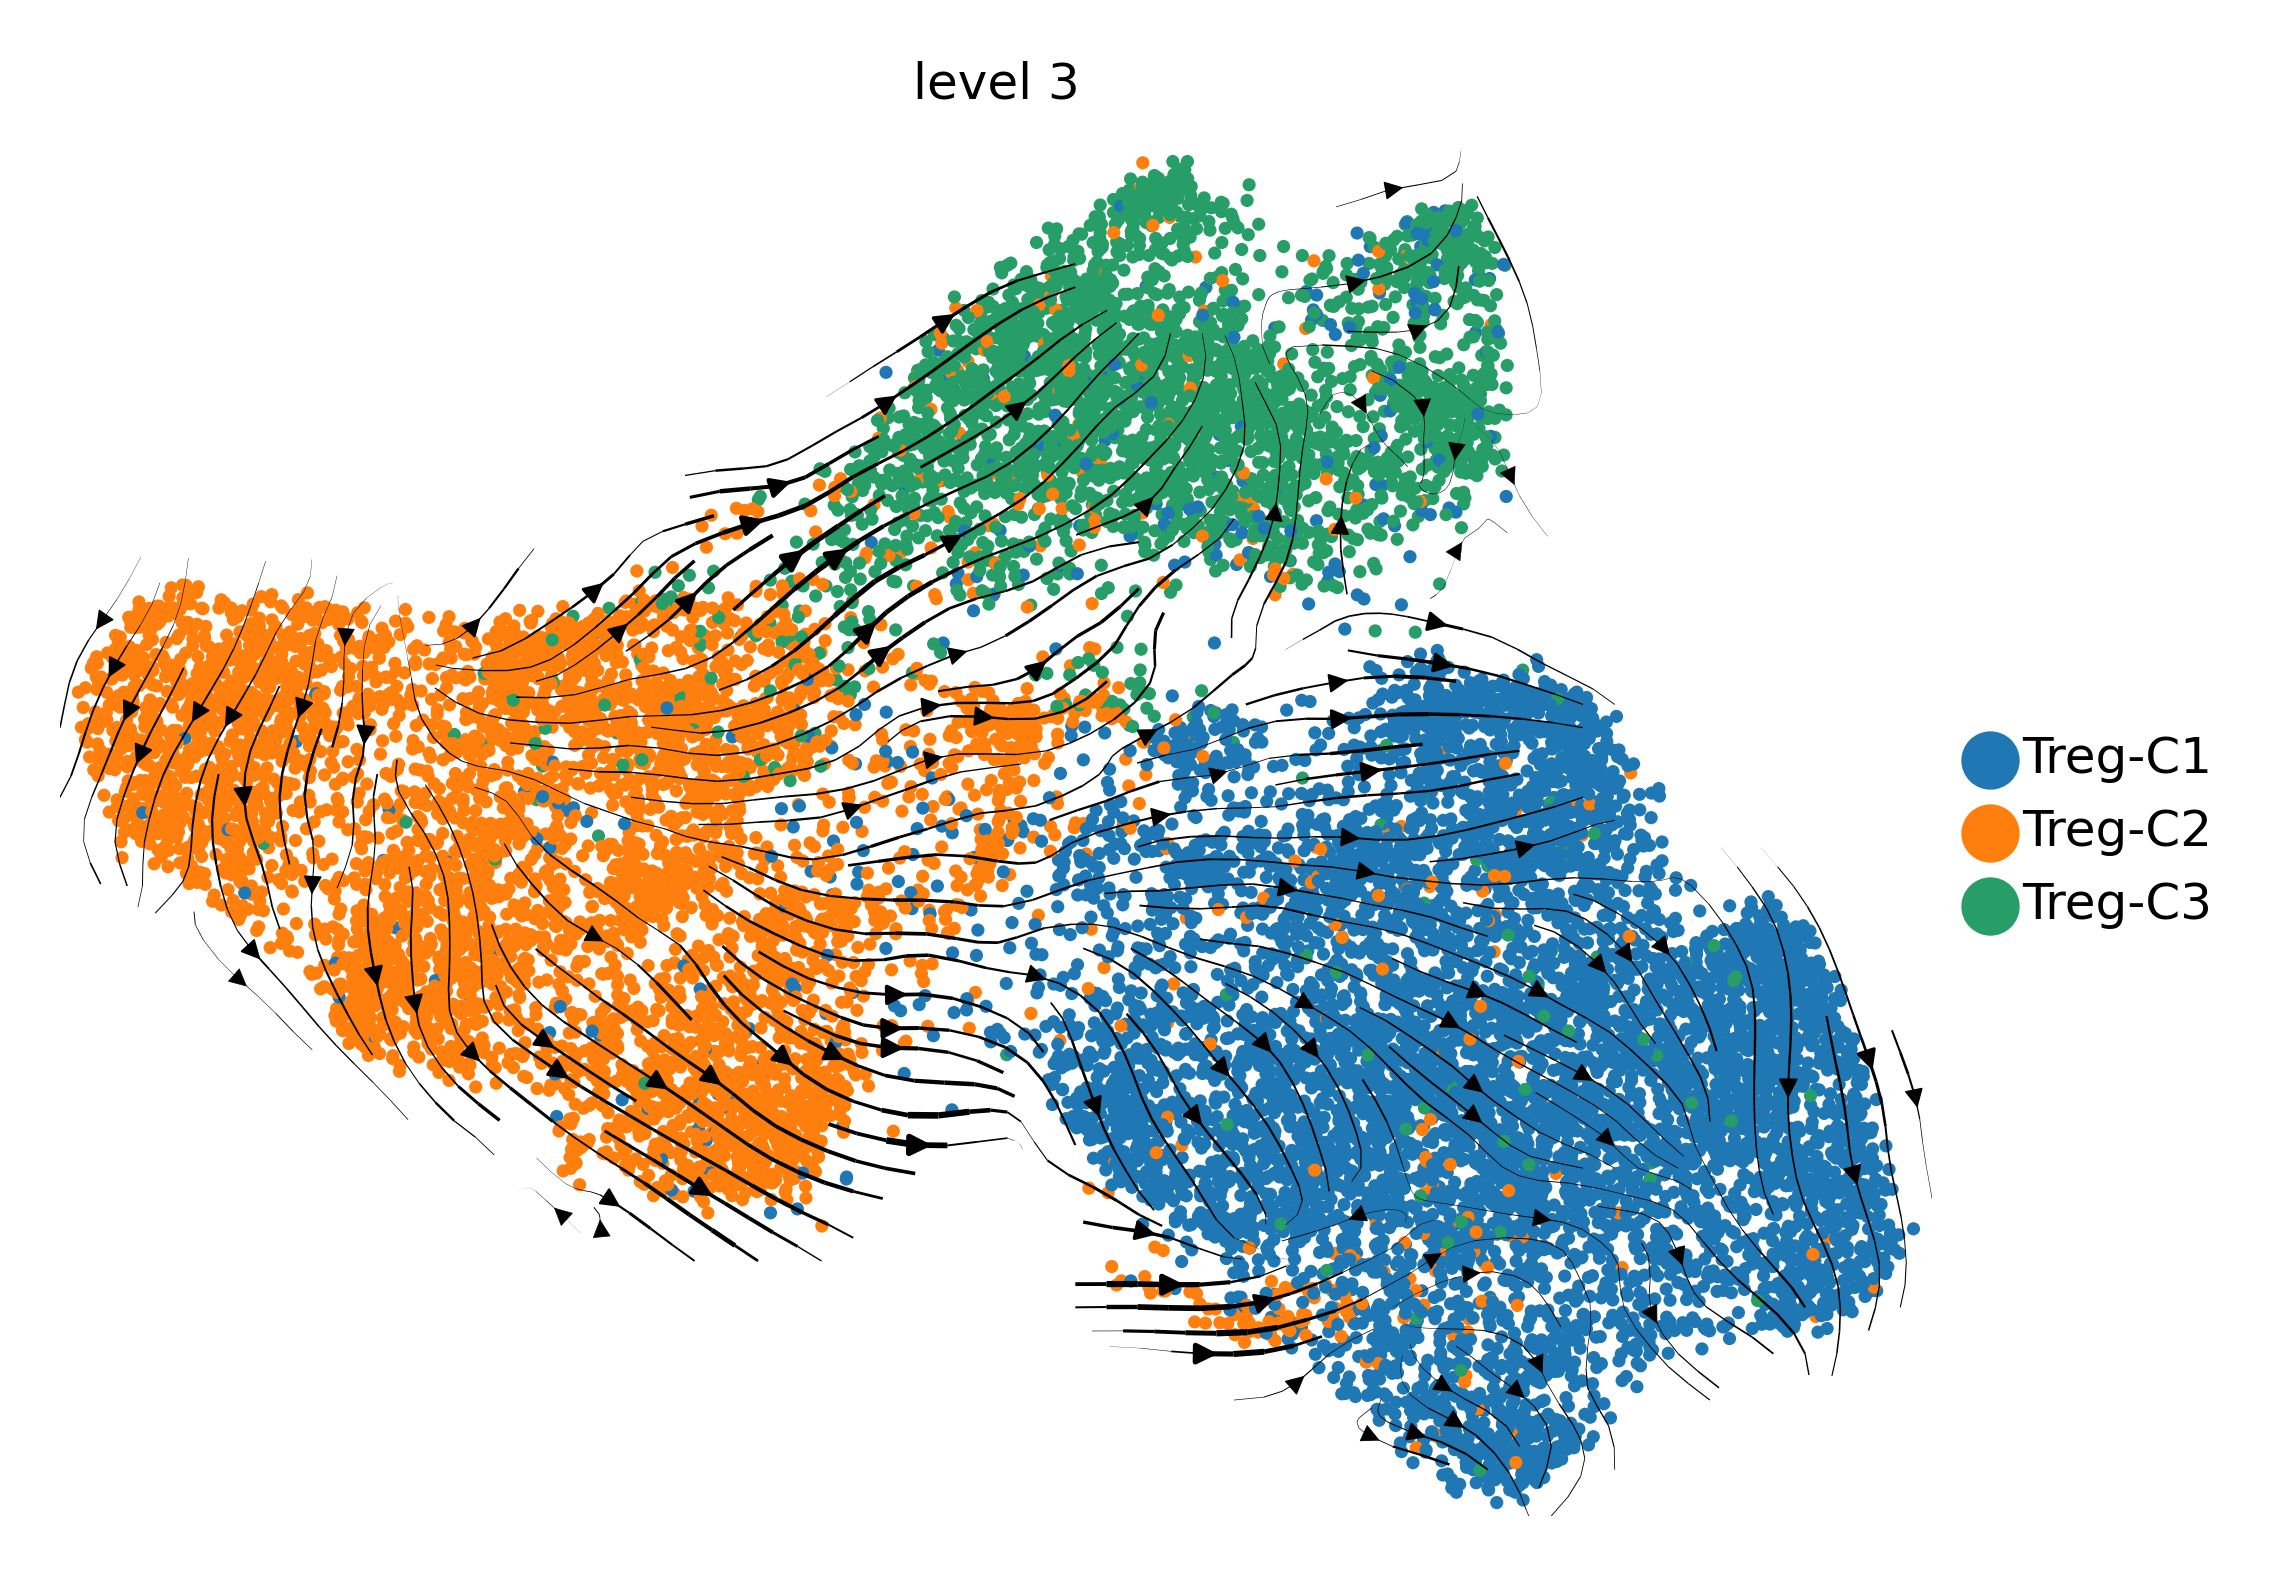

In [15]:
scv.pl.velocity_embedding_stream(vdata, basis='umap', color=['level_3'], linewidth = 0.5, arrow_size=0.5, arrow_color='black', legend_loc='right',
                              figsize=(4, 3), alpha=1, dpi=300, fontsize=6, legend_fontsize=6, size = 10, save=f"{cell}.scvelo_{model}.on_stream.svg")

# steady_state model 

In [16]:
model = "steady"

In [17]:
scv.tl.velocity(vdata, mode='steady_state')
scv.tl.velocity_graph(vdata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/14691 [00:00<?, ?cells/s]

    finished (0:00:25) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvel

saving figure to file ./figures/scvelo_treg.scvelo_steady.on_grid.pdf


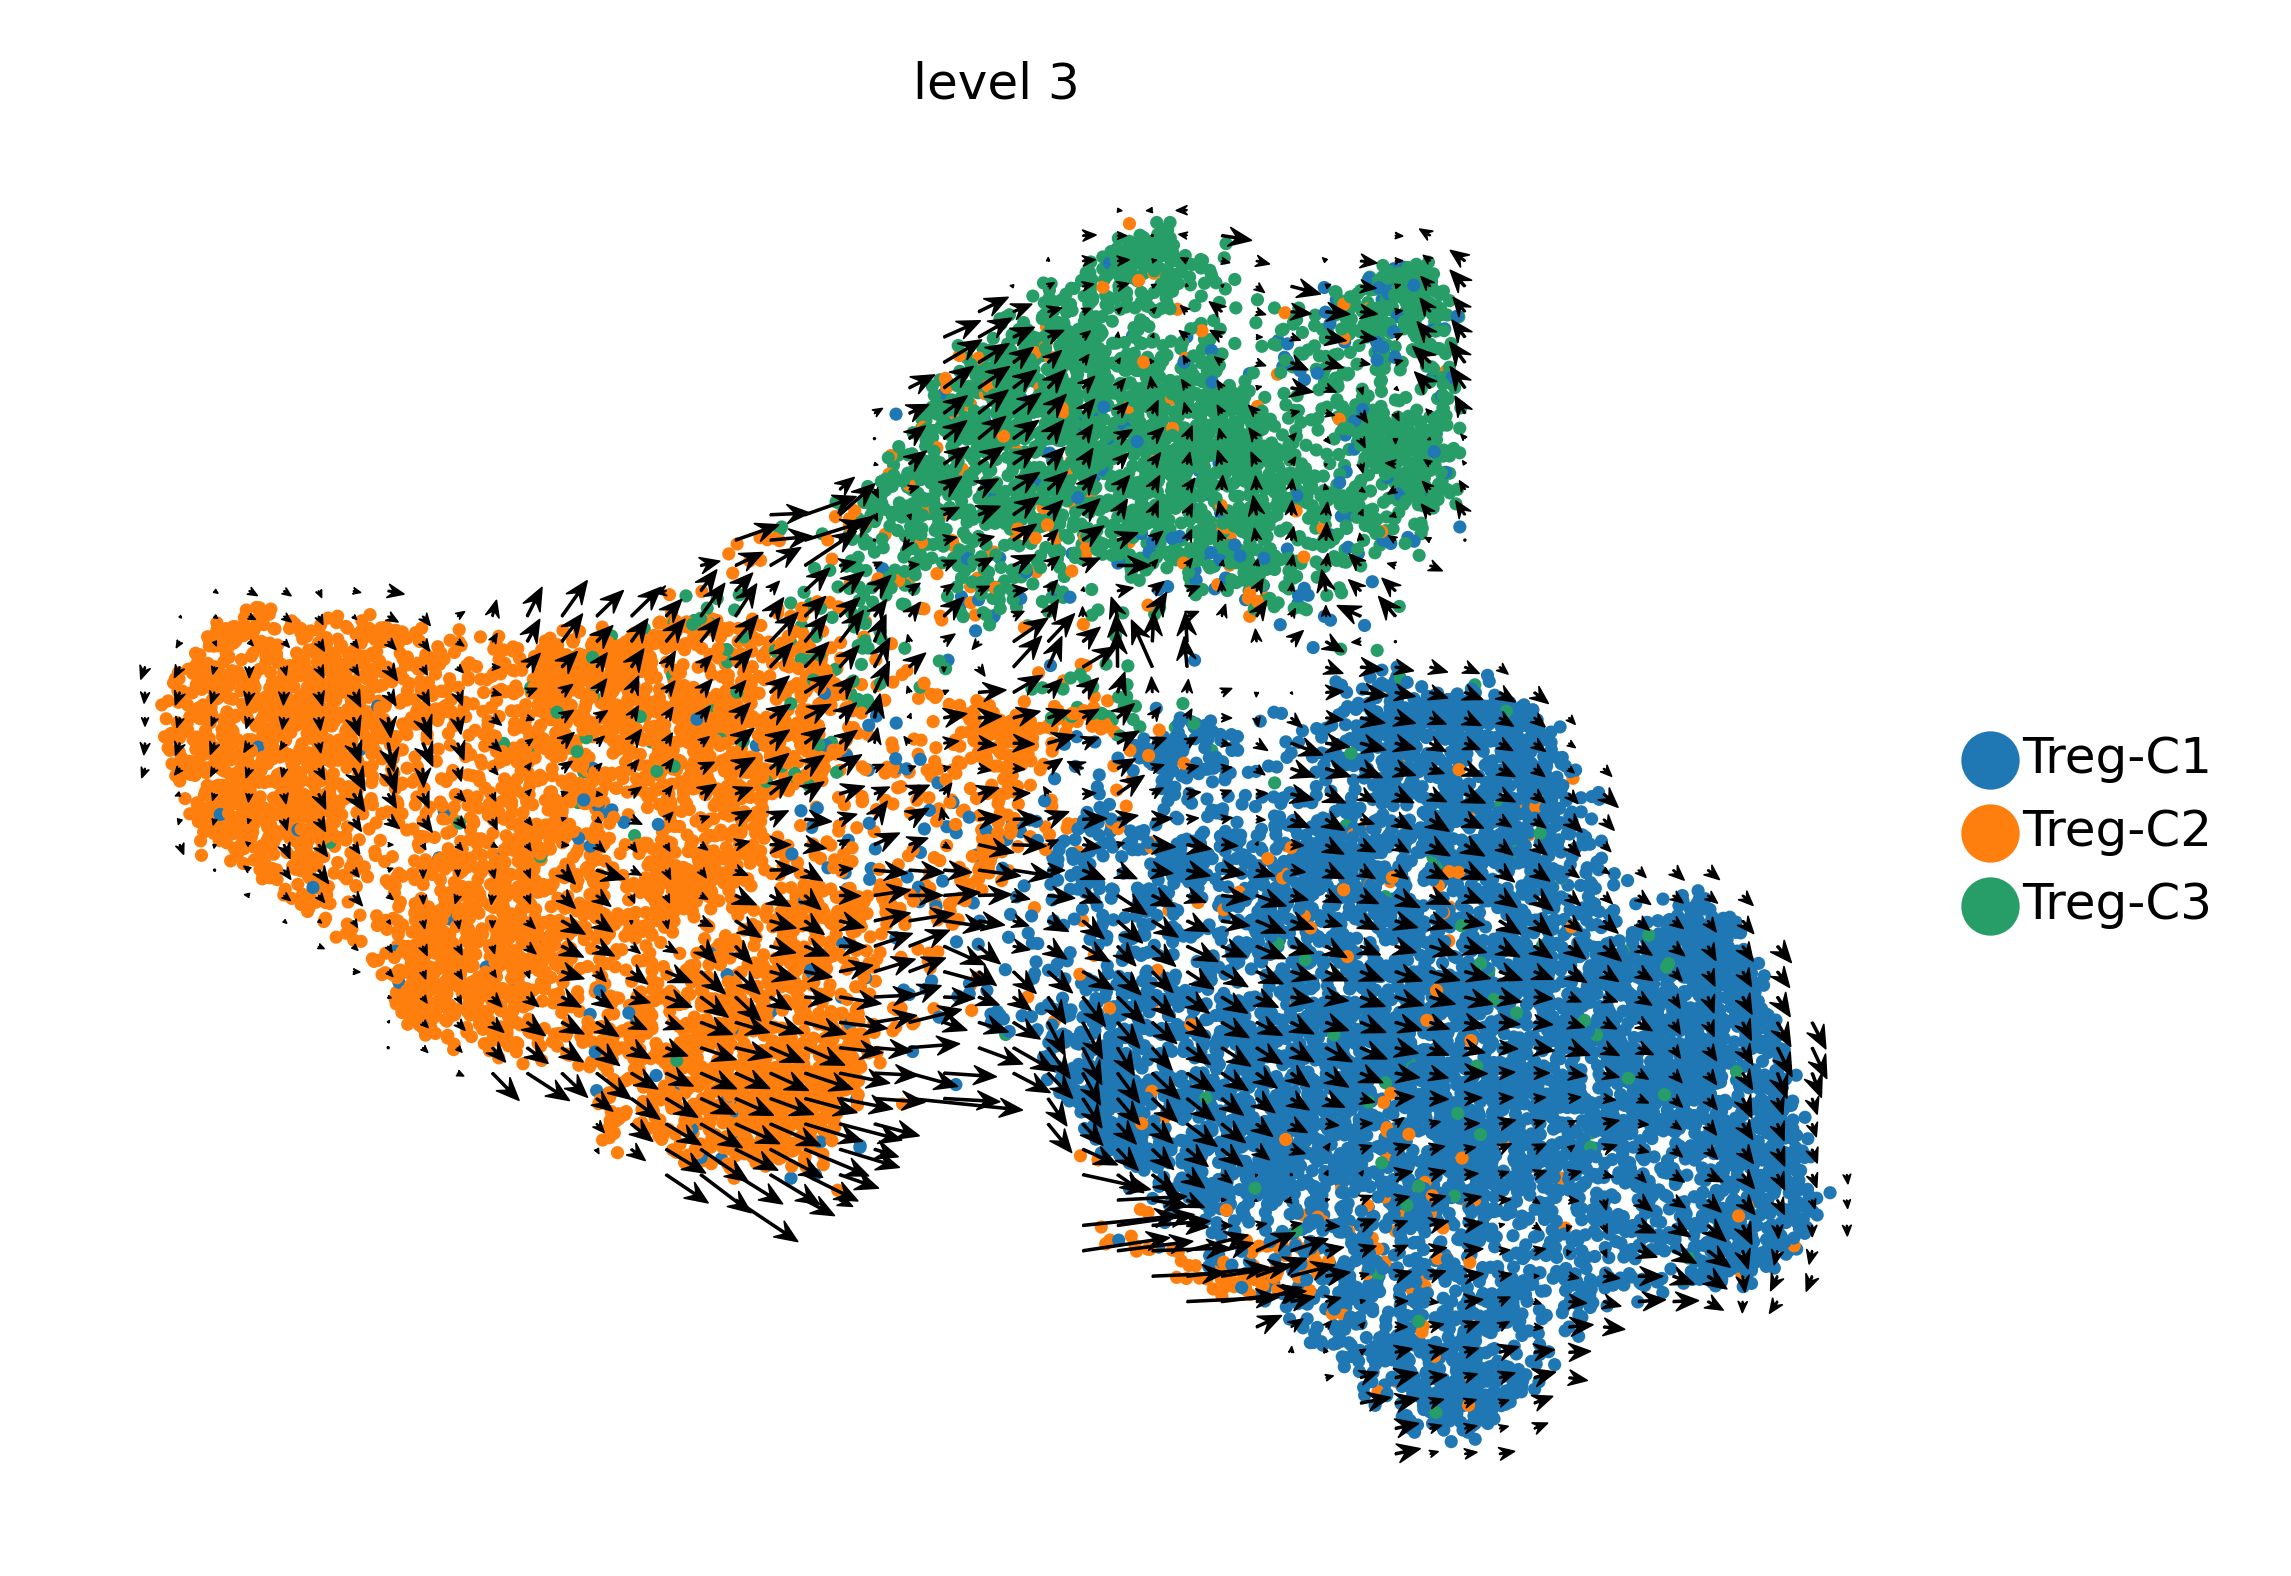

In [18]:
scv.pl.velocity_embedding_grid(vdata, basis='umap', color=['level_3'], arrow_size=2, arrow_length=2, arrow_color='black', legend_loc='right',
                              figsize=(4, 3), alpha=1, dpi=300, fontsize=6, legend_fontsize=6, size = 10, save=f"{cell}.scvelo_{model}.on_grid.pdf")

/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvel

saving figure to file ./figures/scvelo_treg.scvelo_steady.on_stream.svg


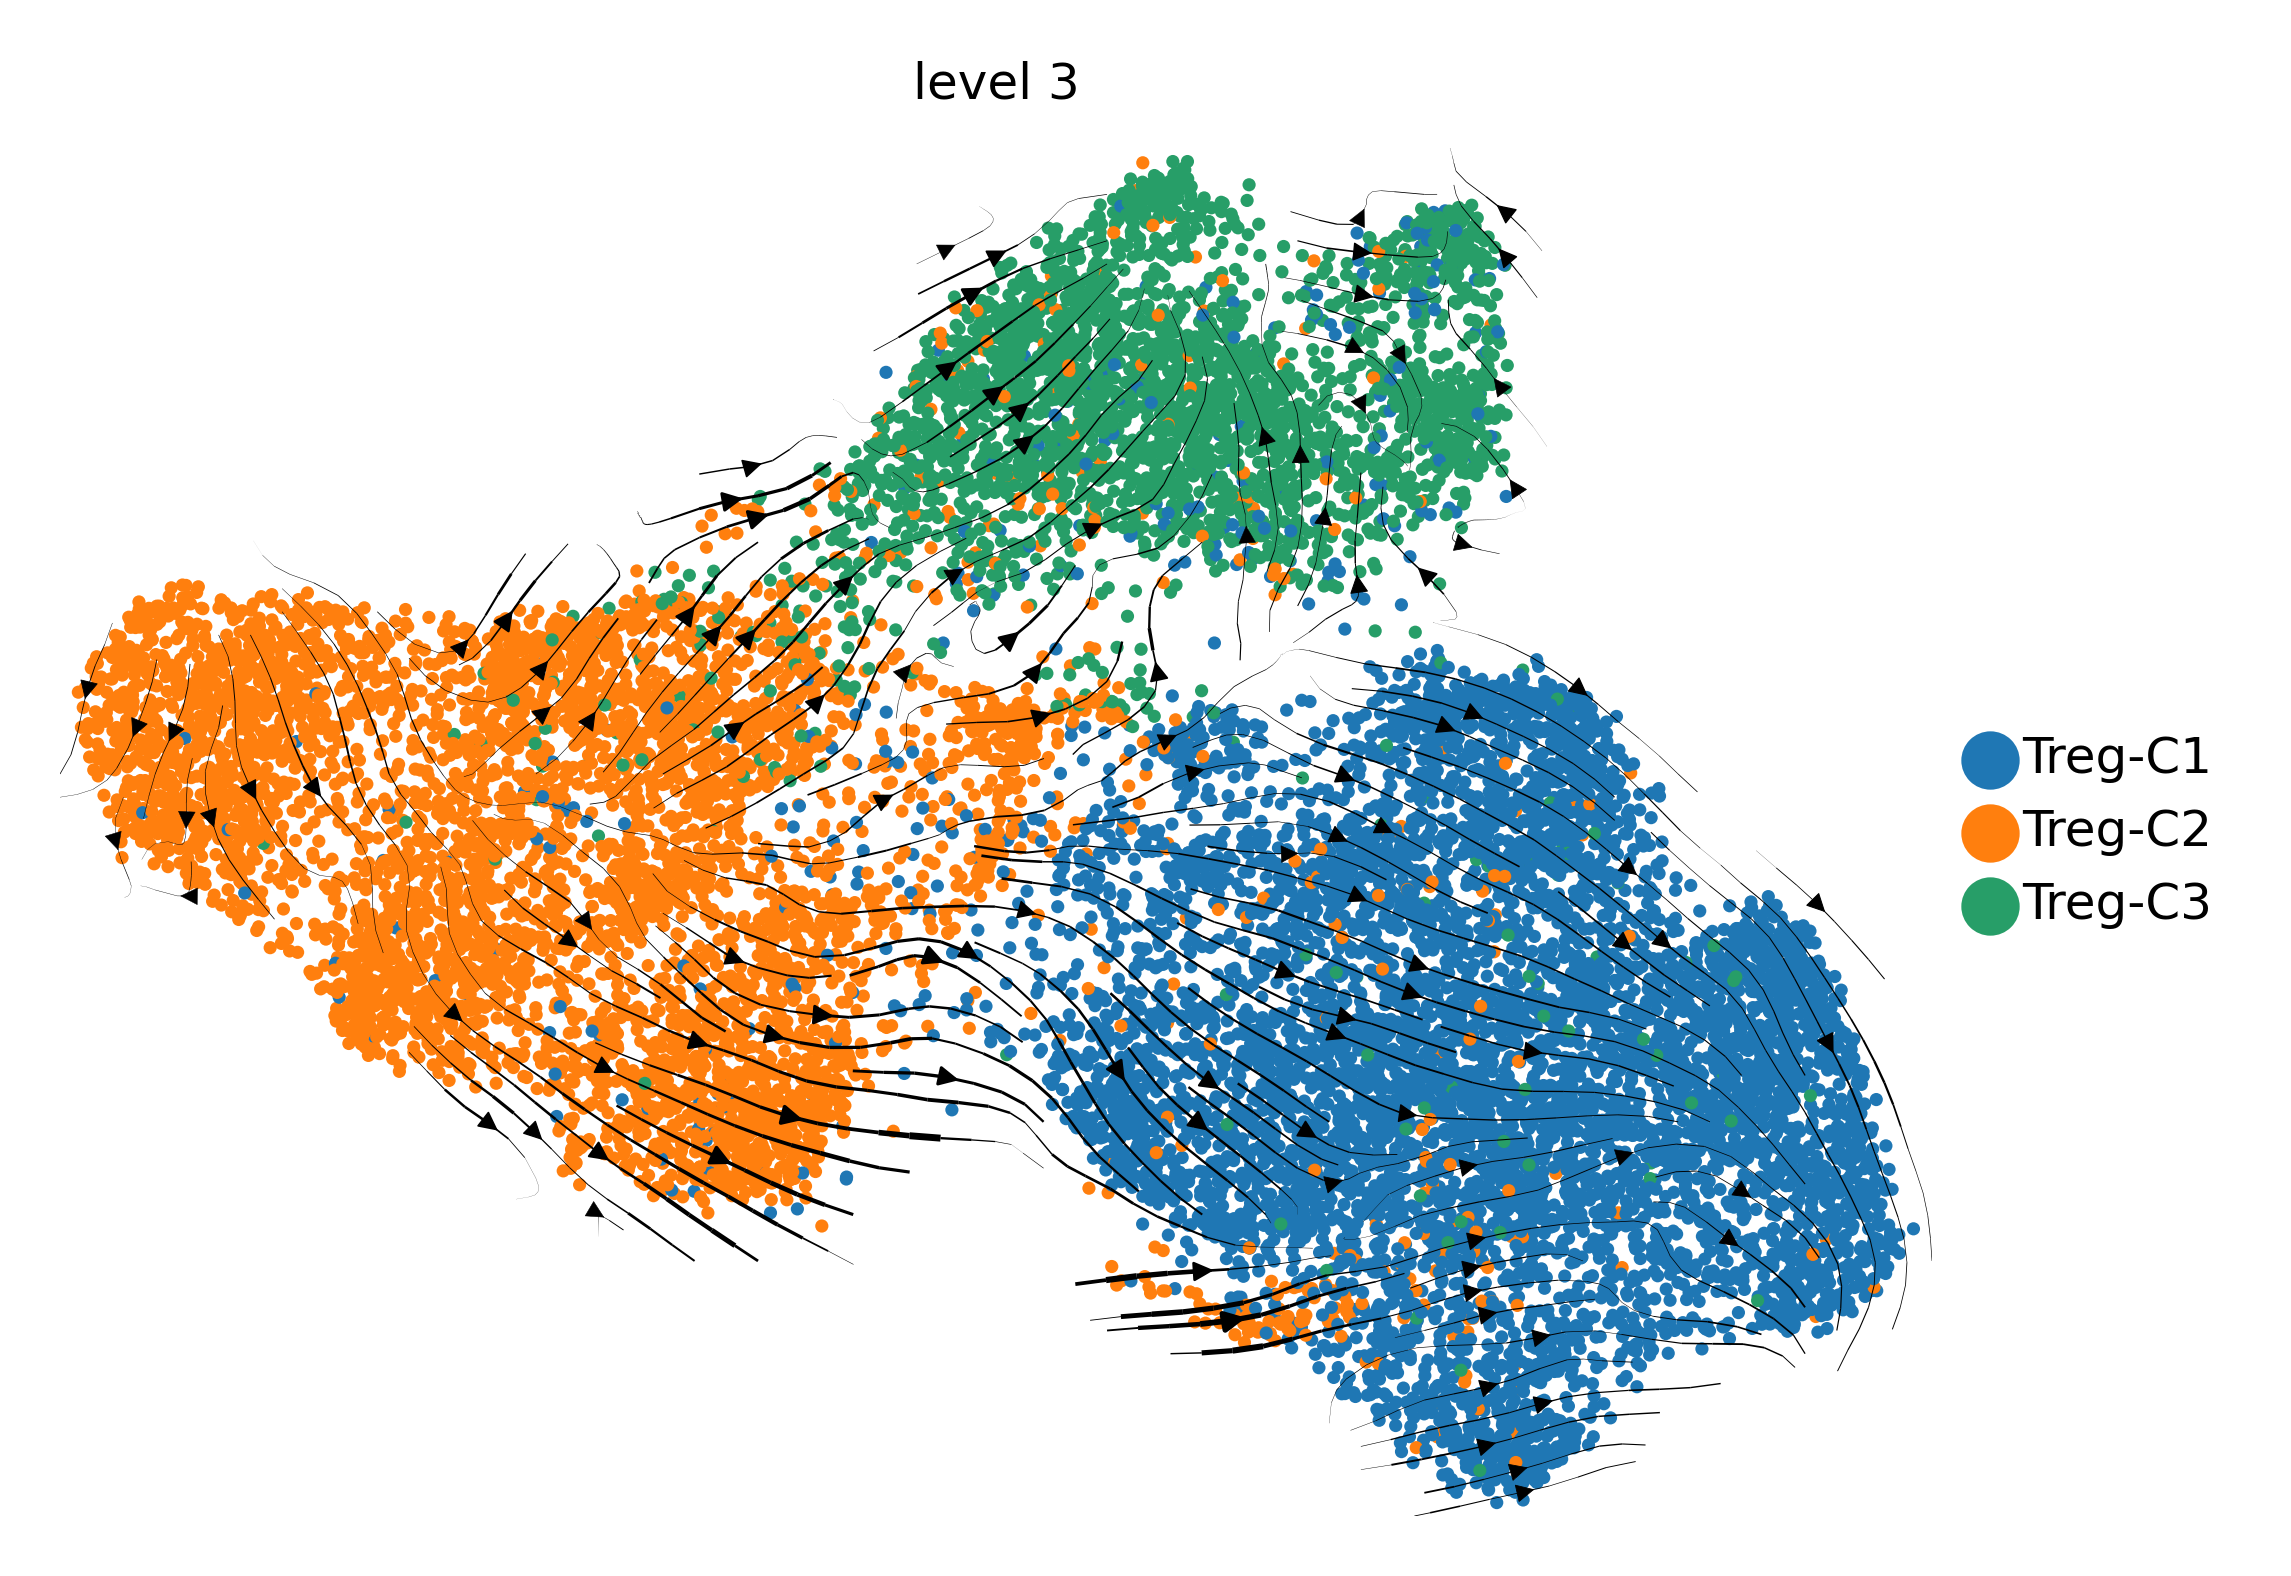

In [19]:
scv.pl.velocity_embedding_stream(vdata, basis='umap', color=['level_3'], linewidth = 0.5, arrow_size=0.5, arrow_color='black', legend_loc='right',
                              figsize=(4, 3), alpha=1, dpi=300, fontsize=6, legend_fontsize=6, size = 10, save=f"{cell}.scvelo_{model}.on_stream.svg")

# dynamical model

In [20]:
model = "dynamical"

In [21]:
scv.tl.recover_dynamics(vdata, n_jobs=12)
scv.tl.velocity(vdata, mode='dynamical')
scv.tl.velocity_graph(vdata)

recovering dynamics (using 12/64 cores)


  0%|          | 0/414 [00:00<?, ?gene/s]

    finished (0:01:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:21) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/14691 [00:00<?, ?cells/s]

    finished (0:00:22) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvel

saving figure to file ./figures/scvelo_treg.scvelo_dynamical.on_grid.pdf


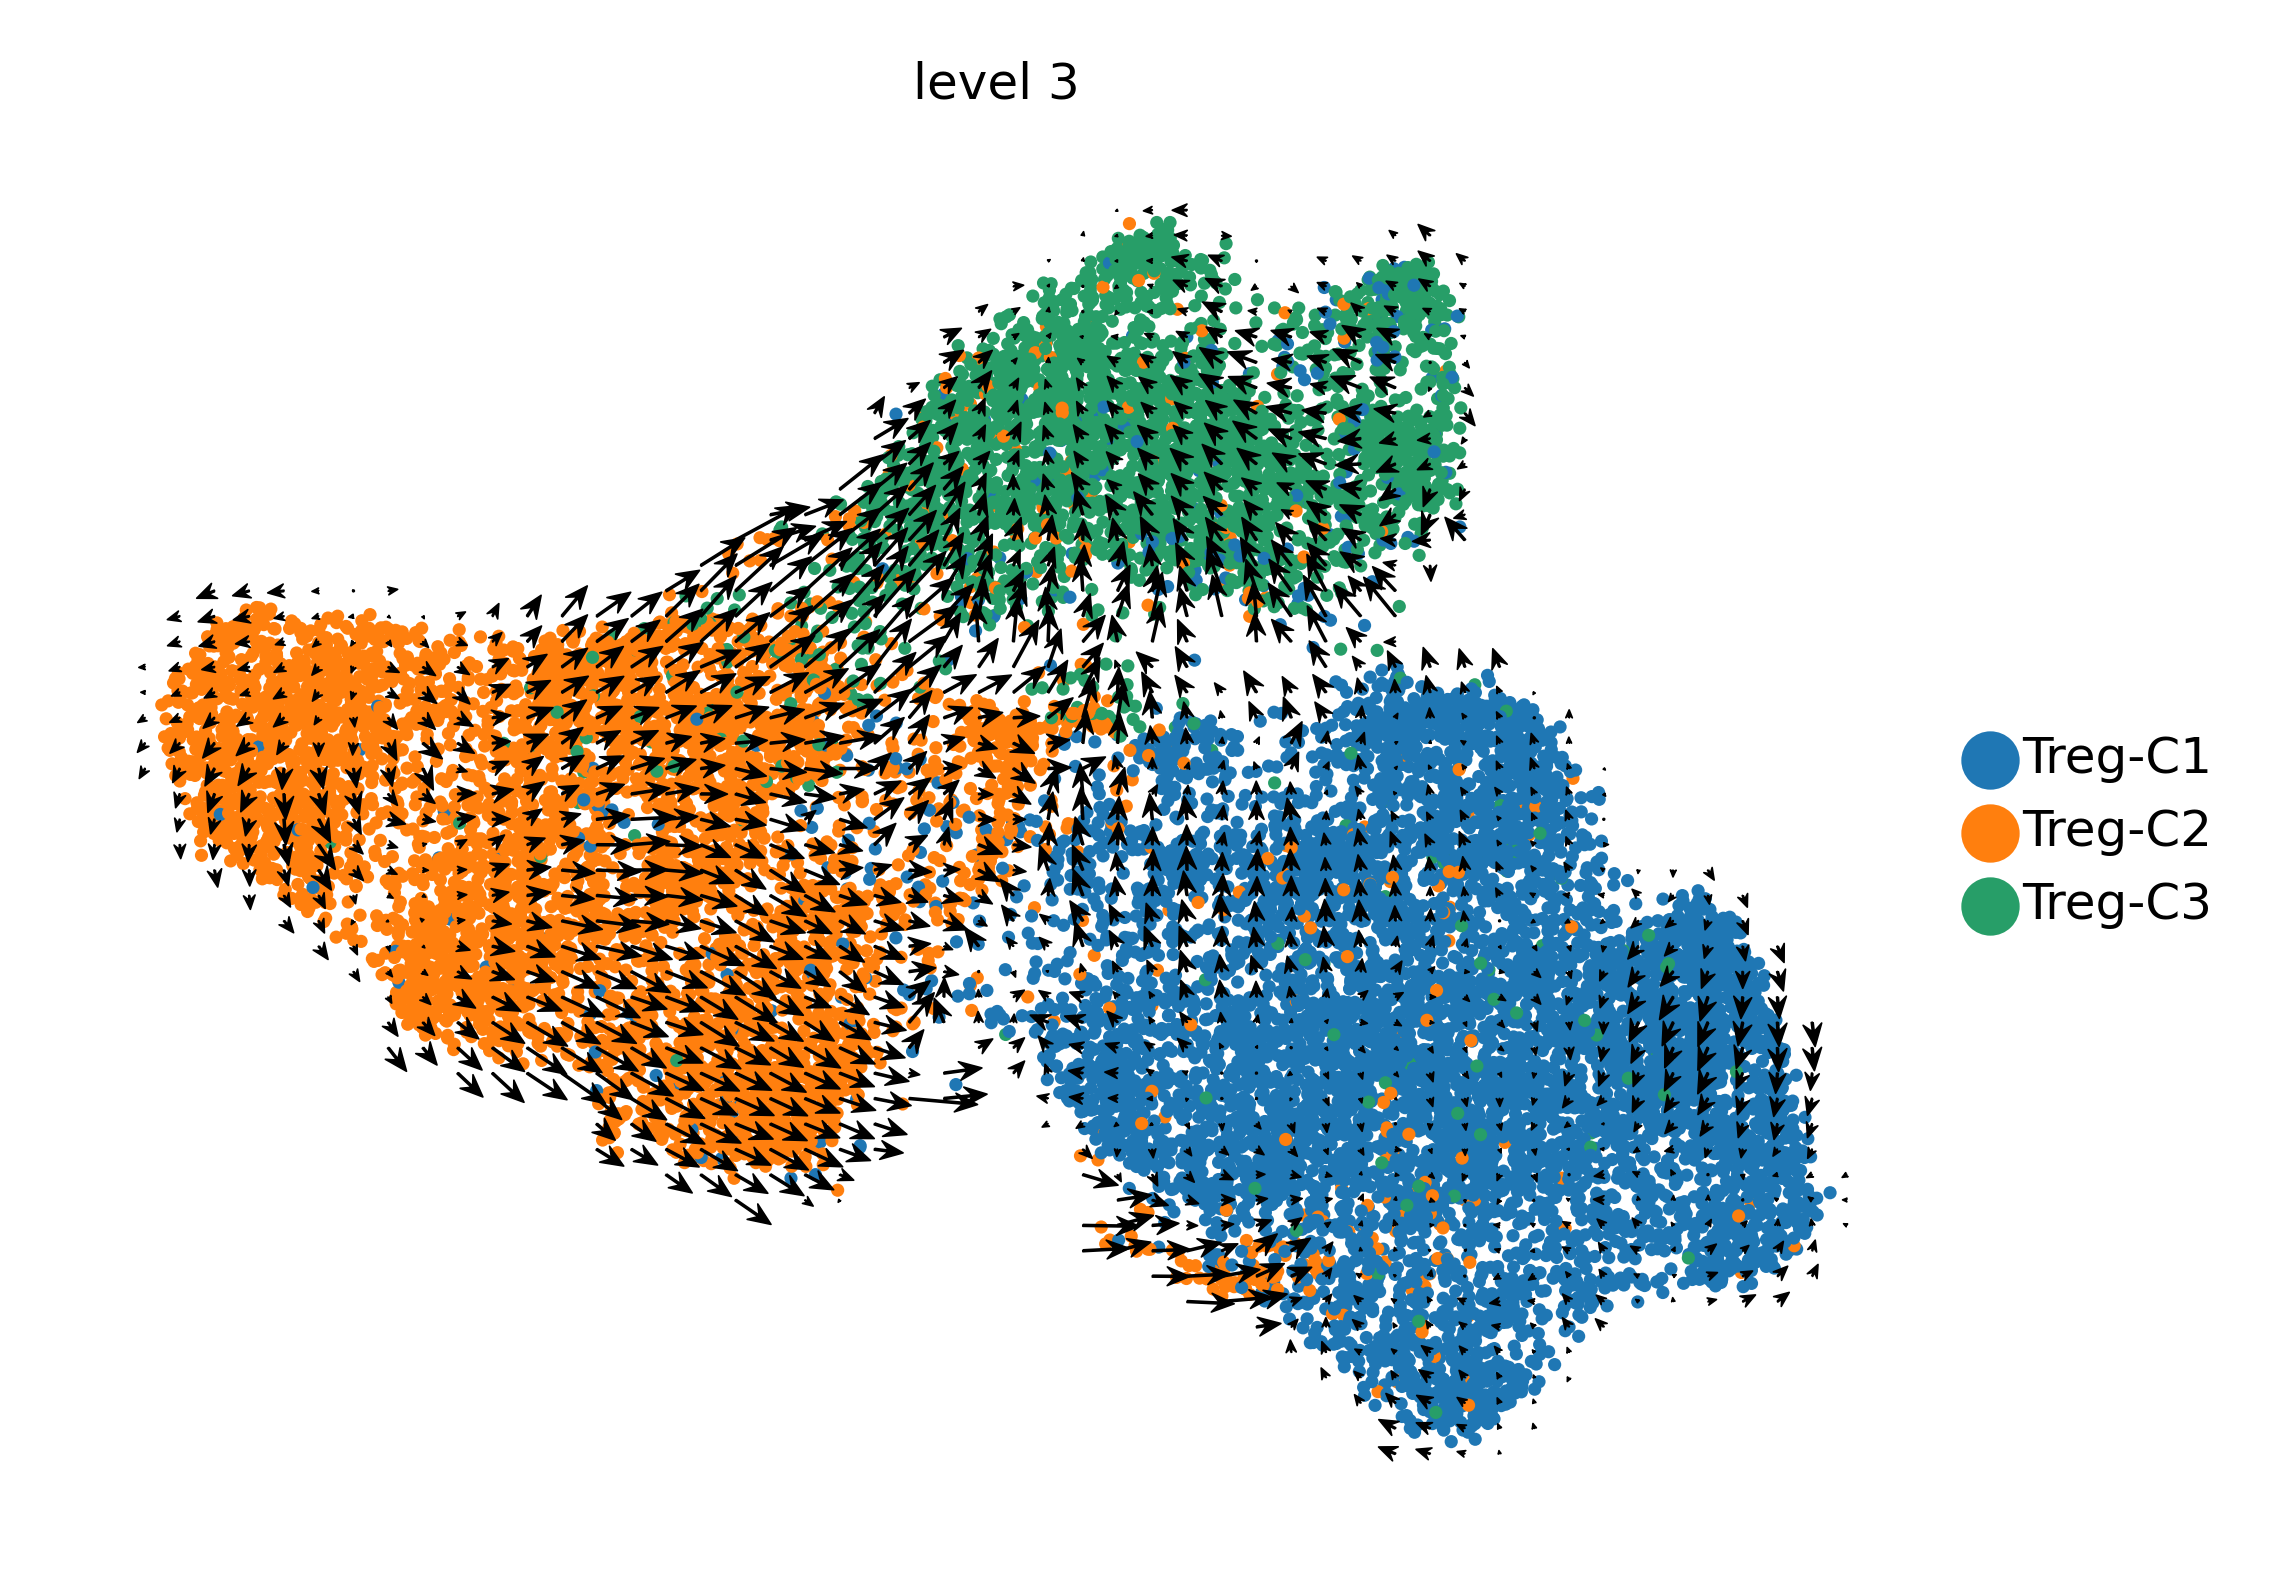

In [22]:
scv.pl.velocity_embedding_grid(vdata, basis='umap', color=['level_3'], arrow_size=2, arrow_length=2, arrow_color='black', legend_loc='right',
                              figsize=(4, 3), alpha=1, dpi=300, fontsize=6, legend_fontsize=6, size = 10, save=f"{cell}.scvelo_{model}.on_grid.pdf")

/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/work/home/software/anaconda3/envs/scvel

saving figure to file ./figures/scvelo_treg.scvelo_dynamical.on_stream.svg


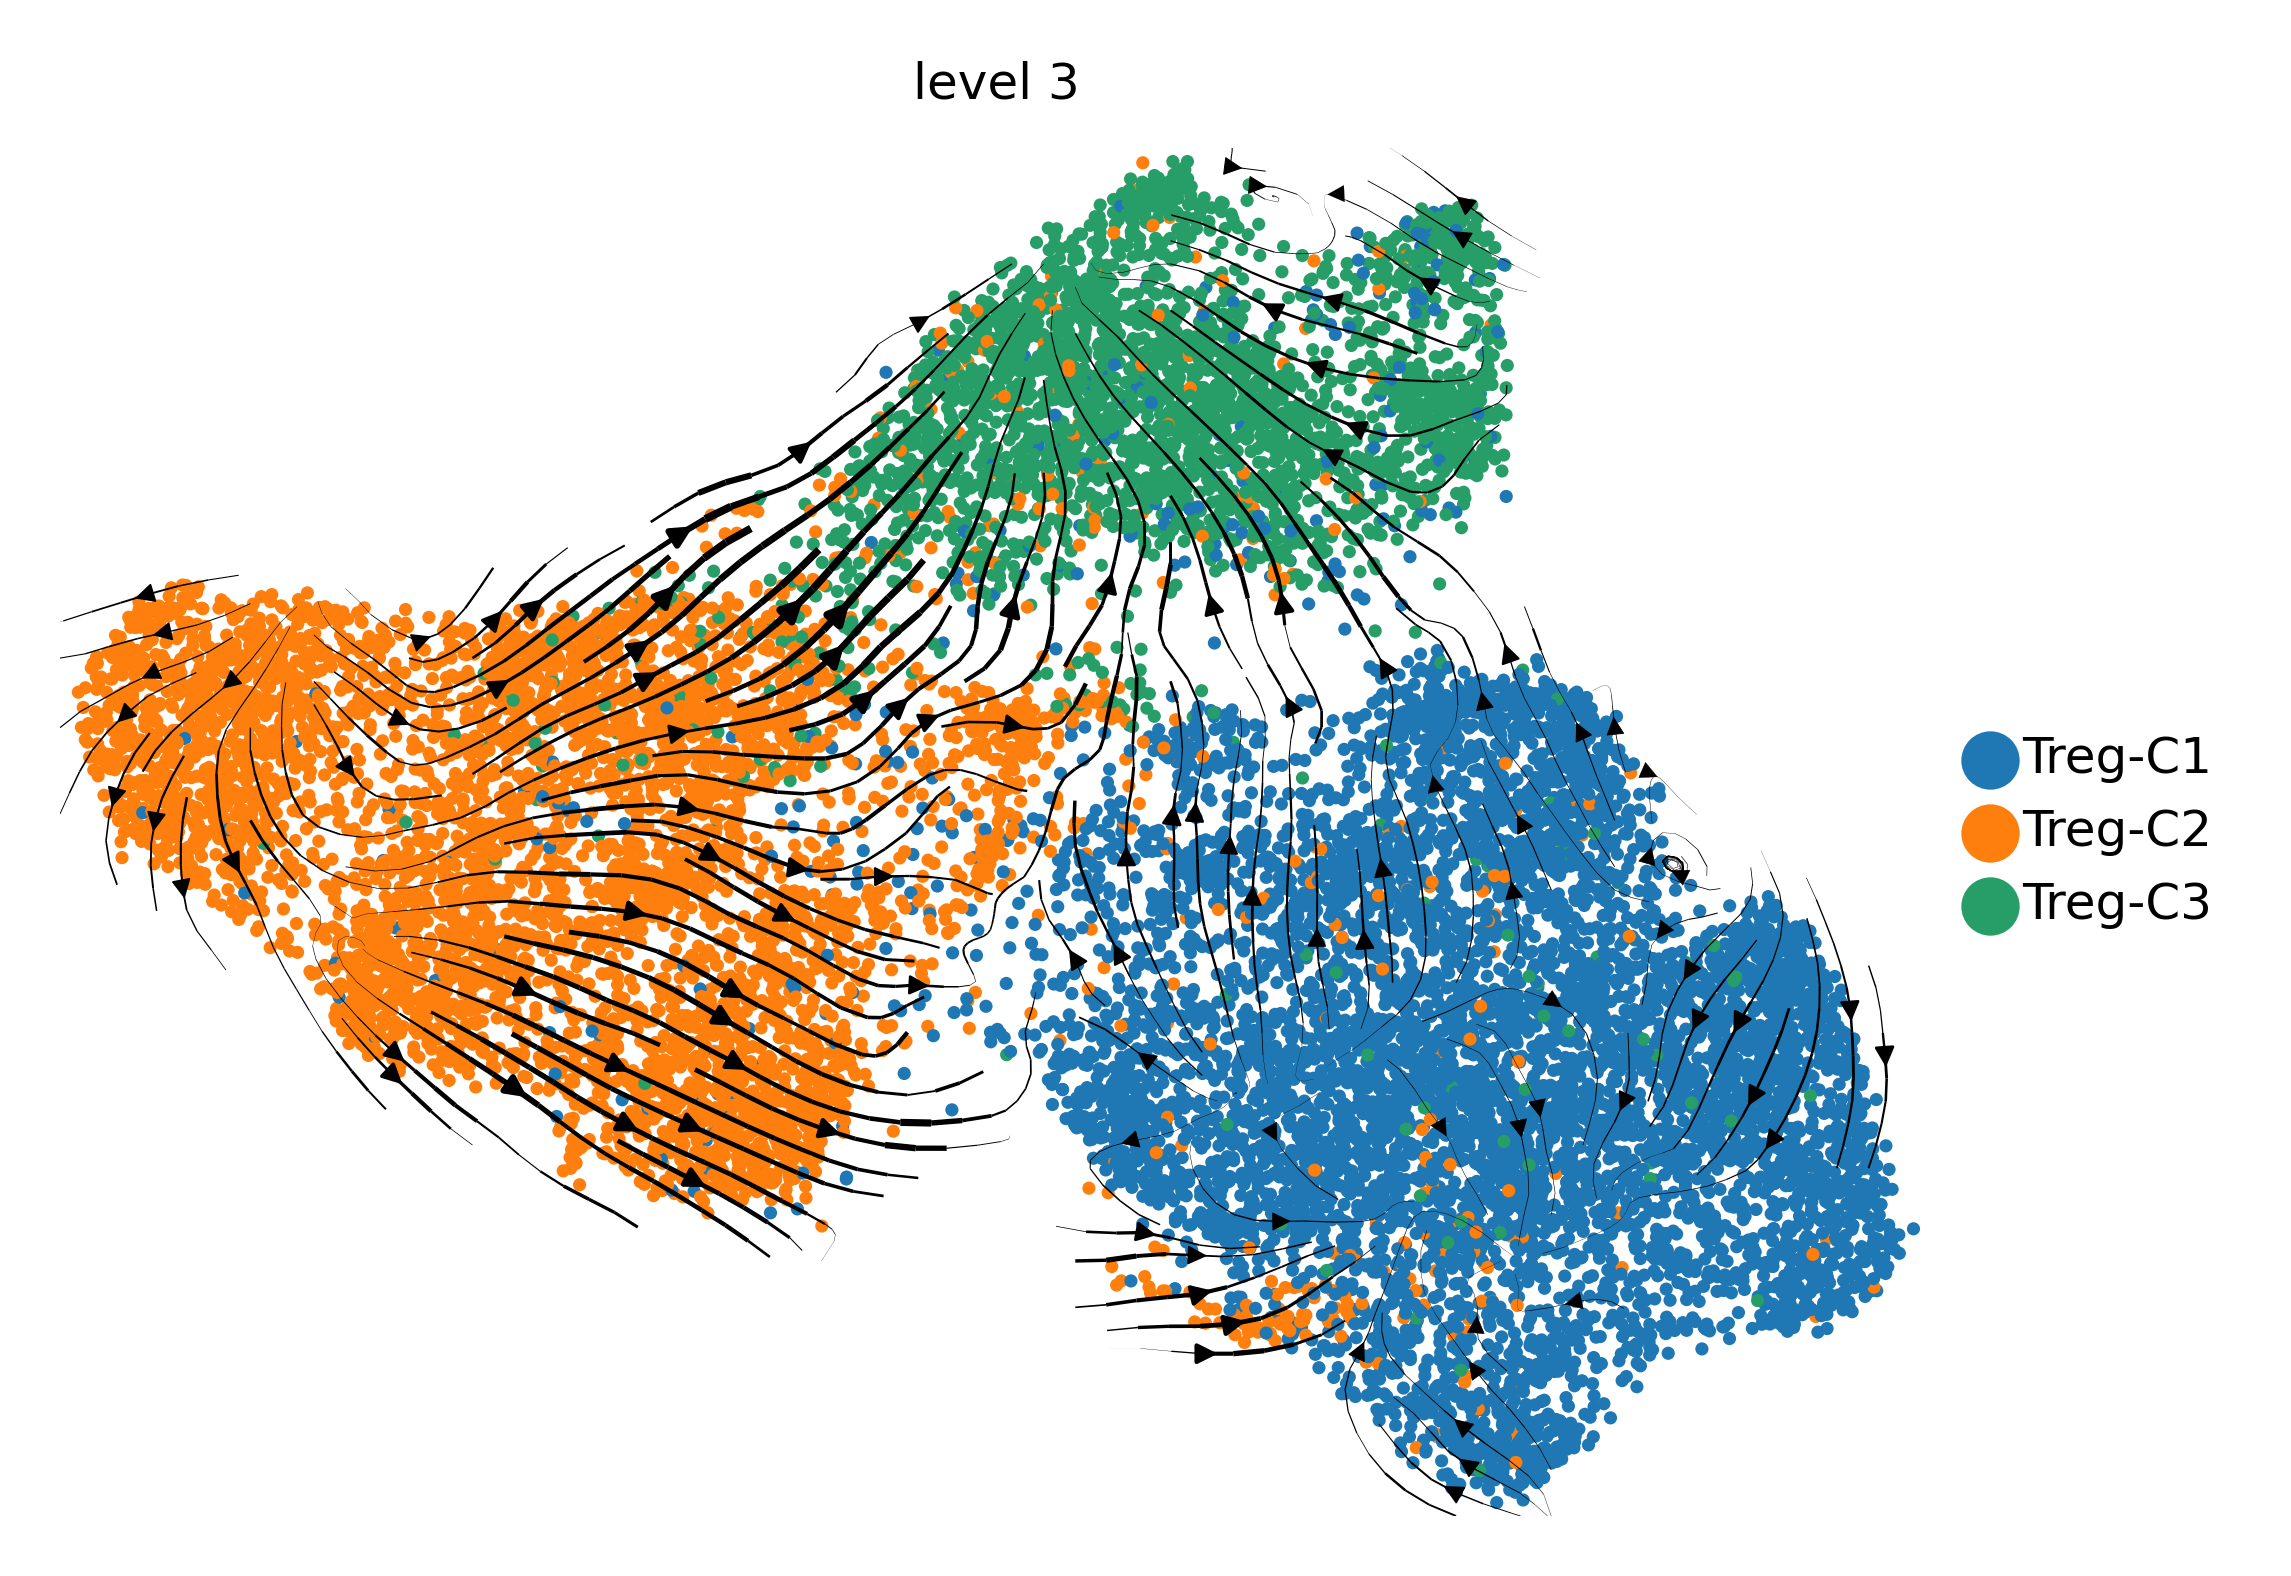

In [23]:
scv.pl.velocity_embedding_stream(vdata, basis='umap', color=['level_3'], linewidth = 0.5, arrow_size=0.5, arrow_color='black', legend_loc='right',
                              figsize=(4, 3), alpha=1, dpi=300, fontsize=6, legend_fontsize=6, size = 10, save=f"{cell}.scvelo_{model}.on_stream.svg")

# Save

In [24]:
vdata.write('%s/output/04.rm_cells/seurat_treg.scvelo.h5ad' %(work_dir))